# 산업수학 Optimizer 정리
<br>
수학과 202021186 명서준
<br><br>

딥러닝 모델의 parameter를 최적화하는데 사용되는 대표적인 optimizer 코드들을 직접 구현 후 정리해보았습니다.<br>
(참고자료 : 텐서플로로 배우는 수치최적화와 딥러닝)
<br>
1. SGD
2. MOMENTUM
3. Adagrad
4. RMSProp
5. Adam

***
0. 우선 필요한 라이브러리들과 자주 사용하는 함수들을 정의하고 시작하겠습니다.<br>
(또한 gradient descent는 모두 안다는 가정 하에 출발하겠습니다.)<br>
(gradient descent의 2가지 문제점 : 1.**local minimum**으로 빠질 수 있는 가능성, 2.**학습률(learning rate)에 민감**함 이 두가지는 기억해주세요.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# 학습할 데이터들을 batch로 나눠주는 함수
def generate_batches(batch_size, features, labels) :
    out_batches = []
    sample_size = len(features)
    for start_i in range(0, sample_size, batch_size) :
        end_i = start_i + batch_size
        batch = [features[start_i:end_i], labels[start_i:end_i]]
        out_batches.append(batch)
    return out_batches

In [3]:
# loss function
def loss(w, x_set, y_set) :
    n = len(x_set)
    val = 0.0
    for i in range(len(x_set)) :
        val += 0.5*(w[0]*x_set[i] + w[1] - y_set[i])**2
    return val/n

# lossfunction의 gradinet 계산
def loss_grad(w, x_set, y_set) :
    n = len(x_set)
    val = np.zeros(len(w))
    for i in range(len(x_set)) :
        error = w[0]*x_set[i] + w[1] - y_set[i]
        val += error*np.array([x_set[i], 1.0])
    return val/n

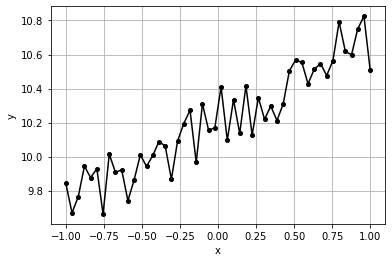

In [4]:
# 간단한 선형회귀를 위한 학습 데이터
np.random.seed(32)
x_train = np.linspace(-1, 1, 50)
f = lambda x : 0.5*x + 10
y_train = f(x_train) + 0.4*np.random.rand(len(x_train))

plt.plot(x_train, y_train, '.k', markersize=8)
plt.plot(x_train, y_train, '-k')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## 1. SGD(Stochastic Gradeint Descent)
<br>
학습 데이터 N개가 있다고 가정을 해봅시다.<br>
일반적인 gradient descent에서는 loss function의 gradient를 계산할 때 N개의 데이터를 모두 사용해 계산하지만,<br>
이는 시간이 너무 많이 걸립니다.<br>
<br>
SGD의 아이디어는 gradient를 계산할 때 N개의 데이터를 모두 계산하지 말고 무작위로 m개를 추출하여 빠르게 gradient를 계산하자는 것입니다.
<br>
정확한 gradient의 값은 아니겠지만, 적당한 m을 설정한다면 빠른속도로 딥러닝 모델을 학습시킬 수 있다는 장점이 있습니다.<br>
<br>

### SGD 알고리즘

1. 초기값 설정
2. 전체데이터 random하게 shuffle
3. 전체 데이터를 적당한 batch로 나눔(각각의 데이터 개수가 m개인 batch)
4. 아래과정을 반복 수행 (아래과정이 하나의 epoch)
    - 첫번째 batch gradeint 계산
    - parameter 업데이트
    - batch가 모두 사용될 때 까지 위 두 과정 반복수행 (모든 batch가 사용되면 한 epoch이 끝난 것)
    
## $$ \theta_{t+1} = \theta_t - \eta \nabla f(\theta_t) $$

In [5]:
# SGD

# 초깃값 설정
batch_size = 5
lr = 0.03
epochs = 30
w0 = np.array([2.0, 4.0]) #parameter의 초깃값
direction = np.zeros_like(w0)

paths= []
batch_loss = []

# 데이터 셔플링
np.random.seed(32)
idx = np.arange(len(x_train))
np.random.shuffle(idx)
shuffle_x_train = x_train[idx]
shuffle_y_train = y_train[idx]

#SGD 알고리즘 수행 (수행결과 epoch 30번 정도 해야 수렴)
for i in range(epochs) :
    for x_batch, y_batch in generate_batches(batch_size, shuffle_x_train, shuffle_y_train) :
        paths.append(w0)
        batch_loss.append(loss(w0, x_batch, y_batch))
        
        grad = loss_grad(w0, x_batch, y_batch)
        direction = -grad
        dw = lr*direction
        w0 = w0 + dw
    print(f'{i:.2f} \t {w0} \t {loss(w0, x_train, y_train)}')

0.00 	 [1.85885309 5.63619978] 	 10.792332723665151
1.00 	 [1.72875693 6.84172381] 	 5.9474471579125705
2.00 	 [1.60941031 7.72988609] 	 3.3021635492445527
3.00 	 [1.50033089 8.38419159] 	 1.8535528475724687
4.00 	 [1.40092887 8.86617749] 	 1.0567290648758585
5.00 	 [1.31055867 9.22119187] 	 0.6155408848160584
6.00 	 [1.22855469 9.48265233] 	 0.36892338419823495
7.00 	 [1.15425552 9.6751844 ] 	 0.22919047121713107
8.00 	 [1.08701992 9.81693439] 	 0.14852870600879056
9.00 	 [1.02623691 9.92127387] 	 0.10080269770978673
10.00 	 [0.97133161 9.99805575] 	 0.07167356159345985
11.00 	 [ 0.9217682  10.05453999] 	 0.05323076221618004
12.00 	 [ 0.87705087 10.09607579] 	 0.04107449241725851
13.00 	 [ 0.83672335 10.12660425] 	 0.03272870551262371
14.00 	 [ 0.80036762 10.14902892] 	 0.02677685149321606
15.00 	 [ 0.76760201 10.16548877] 	 0.022390278559616613
16.00 	 [ 0.73807899 10.17755941] 	 0.019070120487951474
17.00 	 [ 0.7114828  10.18640134] 	 0.01650537779117246
18.00 	 [ 0.68752707 10.1928

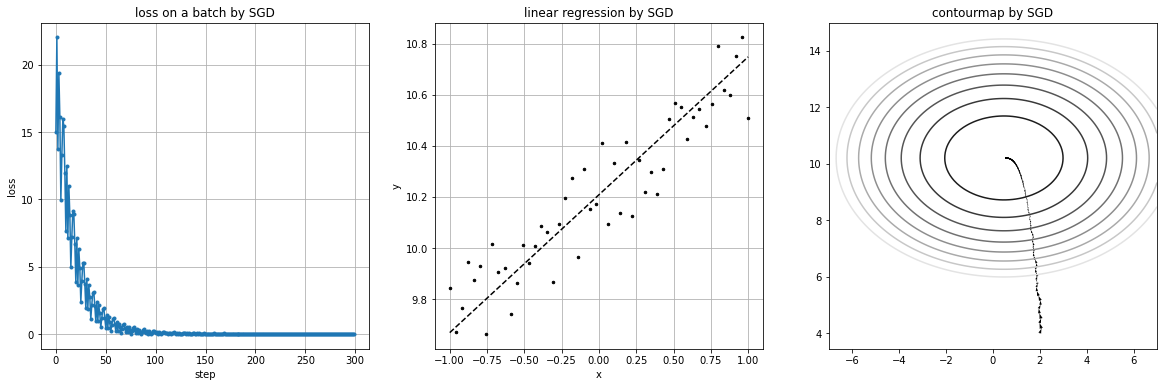

In [6]:
plt.figure(figsize=(20,6))

plt.subplot(1,3,1)
plt.plot(batch_loss, '.-')
plt.grid()
plt.xlabel('step')
plt.ylabel('loss')
plt.title('loss on a batch by SGD')

plt.subplot(1,3,2)
new_paths = np.array(paths).T
plt.plot(x_train, y_train, '.k', markersize=5)
plt.plot(x_train, new_paths[0,-1]*x_train+new_paths[1,-1], 'k--')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.title('linear regression by SGD')

plt.subplot(1,3,3)
w0 = np.linspace(-7, 7, 101)
w1 = np.linspace(5, 15, 101)
w0, w1 = np.meshgrid(w0, w1)
lossw = w0*0
for i in range(w0.shape[0]):
    for j in range(w0.shape[1]):
        wij = np.array([w0[i,j], w1[i,j]])
        lossw[i,j] = loss(wij, x_train, y_train)        
paths = np.array(paths).T
plt.contour(w0, w1, lossw, levels=np.linspace(0,10,10), norm=None, cmap=plt.cm.gray)
plt.quiver(paths[0,:-1], paths[1,:-1], paths[0,1:]-paths[0,:-1], paths[1,1:]-paths[1,:-1], scale_units='xy', angles='xy', scale=1, color='k')
plt.title('contourmap by SGD')

plt.show()

***
## 2. Momentum
<br>
gradient descent의 문제점 : local minimum에서 못빠져나온다.<br>

#### 이를 해결하기위한 Momentum의 아이디어 : gradient가 0이 나오더라도 내가 가던 방향으로 조금 더 가보자!

<br>
(전 단계의 업데이트 방향의 누적합에 현재 단계의 업데이트 방향을 동시에 사용)



### Momentum 수식
<br>
- 전체적인 알고리즘 방식은 gradient descent와 동일 <br>
- 누적된 업데이터 방향 v(t)를 추가 ( : momentum이 움직이던 방향, 관성, 속도를 나타내어 velocity의 v)<br>
- v(t)를 계산할 때 오래전 단계의 업데이트 방향의 영향성을 줄여주는 상수m (0~1사이의 값)
<br>


##  $$ v_{t+1} = \alpha v_t + (1 - \alpha) \nabla f(\theta_t) $$ 
##  $$ \theta_{t+1} = \theta_t - \eta v_{t+1} $$

In [7]:
# Momentum

# 초깃값 설정
batch_size = 5
epochs = 10
w0 = np.array([2.0, 4.0]) #parameter 초깃값
lr = 0.03 #learning_rate
alpha = 0.9 #momentum v의 계수 alpha
velocity = np.zeros_like(w0) # v의 초깃값 0

paths= []
batch_loss = []

# 데이터 셔플링
np.random.seed(32)
idx = np.arange(len(x_train))
np.random.shuffle(idx)
shuffle_x_train = x_train[idx]
shuffle_y_train = y_train[idx]

# Momentum 알고리즘 수행
for i in range(epochs) :
    for x_batch, y_batch in generate_batches(batch_size, shuffle_x_train, shuffle_y_train) :
        paths.append(w0)
        batch_loss.append(loss(w0, x_batch, y_batch))
        
        grad = loss_grad(w0, x_batch, y_batch)
        velocity = alpha*velocity - lr*grad
        dw = velocity
        w0 = w0 + dw
    print(f'{i:.2f} \t {w0} \t {loss(w0, x_train, y_train)}')

0.00 	 [1.82537669 9.83871696] 	 0.39232353681843485
1.00 	 [ 0.90309787 12.43517592] 	 2.517851269017123
2.00 	 [0.30188108 9.98888848] 	 0.03544190611955501
3.00 	 [0.20666669 9.46117339] 	 0.2977098565689837
4.00 	 [ 0.34222126 10.39657204] 	 0.026960674968094876
5.00 	 [ 0.46786184 10.436371  ] 	 0.0323182219861102
6.00 	 [ 0.51430761 10.10478618] 	 0.01200016936472331
7.00 	 [ 0.50575444 10.14258243] 	 0.008686446439756973
8.00 	 [ 0.48218178 10.25214551] 	 0.00730068264856904
9.00 	 [ 0.46770885 10.22176233] 	 0.0064184150856804205


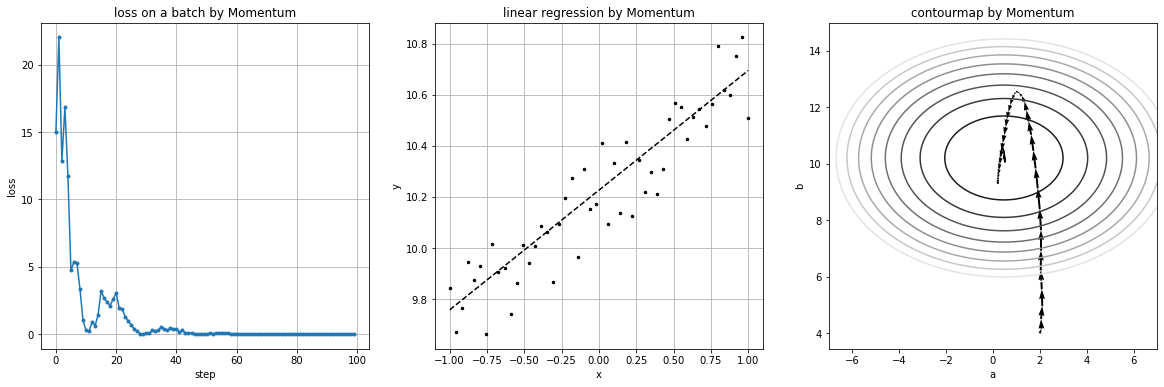

In [8]:
plt.figure(figsize=(20,6))

plt.subplot(1,3,1)
plt.plot(batch_loss, '.-')
plt.grid()
plt.xlabel('step')
plt.ylabel('loss')
plt.title('loss on a batch by Momentum')

plt.subplot(1,3,2)
new_paths = np.array(paths).T
plt.plot(x_train, y_train, '.k', markersize=5)
plt.plot(x_train, new_paths[0,-1]*x_train+new_paths[1,-1], 'k--')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.title('linear regression by Momentum')

plt.subplot(1,3,3)
w0 = np.linspace(-7, 7, 101)
w1 = np.linspace(5, 15, 101)
w0, w1 = np.meshgrid(w0, w1)
lossw = w0*0
for i in range(w0.shape[0]):
    for j in range(w0.shape[1]):
        wij = np.array([w0[i,j], w1[i,j]])
        lossw[i,j] = loss(wij, x_train, y_train)        
paths = np.array(paths).T
plt.contour(w0, w1, lossw, levels=np.linspace(0,10,10), norm=None, cmap=plt.cm.gray)
plt.quiver(paths[0,:-1], paths[1,:-1], paths[0,1:]-paths[0,:-1], paths[1,1:]-paths[1,:-1], scale_units='xy', angles='xy', scale=1, color='k')
plt.xlabel('a')
plt.ylabel('b')
plt.title('contourmap by Momentum')

plt.show()

momentum의 contour map을 확인하면 일반적인 gradient descent와는 다르게 parameter의 수렴 경로가 곧바로 최솟값을 갖는 위치로 가는 것이 아니라 가던방향으로 계속 쭉 가다가 한번정도 휘어 수렴하는 것을 볼 수 있습니다. 

***
## 3. Adagrad
<br>
gradient descent의 문제점 : learning_rate의 영향을 많이 받는다. <br>
Momentum의 문제점 : Local Minimum에서 크게 지나치다가 Global minimum을 지나칠 수도 있음 <br>

#### 이를 해결하기위한 Adagrad의 아이디어 : 학습을 하면서 learning_rate를 조절해보자!
<br>
(gradient의 크기가 큰 방향은 조심히 살짝 움직이고, 크기가 작은 방향은 확 많이 지나가자!)



### Adagrad 수식
<br>
- 전체적인 알고리즘 방식은 gradient descent와 동일 <br>
- r : gradient의 크기의 제곱을 계속해서 누적해서 나눠줌 <br>
- delta : 분모가 0이 되는 것을 막기 위해 아주 작은 값을 더해줌
<br>

##   $$ r_{t+1} = r_t + (\nabla f(\theta_t))^2  $$
##   $$ \theta_{t+1} = \theta_t - \frac{\epsilon}{\sqrt{r_{t+1} + \delta}} \nabla f(\theta_t) $$

In [9]:
# Adagrad

# 초깃값 설정
batch_size = 5
epochs = 10
w0 = np.array([2.0, 4.0]) #parameter 초깃값
epsilon = 1.0 # adagrad수식에서 업데이트할 learning_rate 분모
delta = 1e-7 # adagrad수식에서 업데이트할 learning_rate 분자 0 방지를 위한 delta값
r = np.zeros_like(w0) #adagrad수식에서 학습률을 그방향의 반비례로 설정해주는 r의 초깃값 0

paths= []
batch_loss = []

# 데이터 셔플링
np.random.seed(32)
idx = np.arange(len(x_train))
np.random.shuffle(idx)
shuffle_x_train = x_train[idx]
shuffle_y_train = y_train[idx]

# Adagrad 알고리즘 수행
for i in range(epochs) :
    for x_batch, y_batch in generate_batches(batch_size, shuffle_x_train, shuffle_y_train) :
        paths.append(w0)
        batch_loss.append(loss(w0, x_batch, y_batch))
        
        grad = loss_grad(w0, x_batch, y_batch)
        direction = -grad
        r = r + grad**2
        lr = epsilon / (delta+np.sqrt(r))
        dw = lr*direction
        w0 = w0+dw
    print(f'{i:.2f} \t {w0} \t {loss(w0, x_train, y_train)}')

0.00 	 [1.47133478 8.15718844] 	 2.2832172155700774
1.00 	 [0.99981019 9.29365617] 	 0.4729894597611507
2.00 	 [0.75227617 9.79033781] 	 0.10732039174581036
3.00 	 [ 0.62007982 10.01722915] 	 0.028392431736670134
4.00 	 [ 0.54925649 10.12176727] 	 0.011108512492564846
5.00 	 [ 0.51133177 10.17001076] 	 0.007328303940753917
6.00 	 [ 0.49104954 10.19227769] 	 0.0065172942447519954
7.00 	 [ 0.48021696 10.20255268] 	 0.0063538520669565056
8.00 	 [ 0.47443836 10.20729233] 	 0.006327029517109335
9.00 	 [ 0.47135909 10.20947762] 	 0.00632621179071743


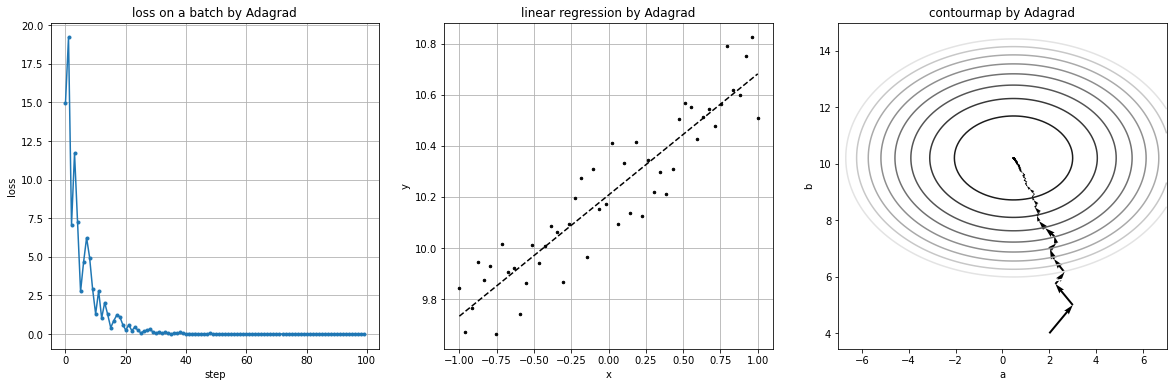

In [10]:
plt.figure(figsize=(20,6))

plt.subplot(1,3,1)
plt.plot(batch_loss, '.-')
plt.grid()
plt.xlabel('step')
plt.ylabel('loss')
plt.title('loss on a batch by Adagrad')

plt.subplot(1,3,2)
new_paths = np.array(paths).T
plt.plot(x_train, y_train, '.k', markersize=5)
plt.plot(x_train, new_paths[0,-1]*x_train+new_paths[1,-1], 'k--')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.title('linear regression by Adagrad')

plt.subplot(1,3,3)
w0 = np.linspace(-7, 7, 101)
w1 = np.linspace(5, 15, 101)
w0, w1 = np.meshgrid(w0, w1)
lossw = w0*0
for i in range(w0.shape[0]):
    for j in range(w0.shape[1]):
        wij = np.array([w0[i,j], w1[i,j]])
        lossw[i,j] = loss(wij, x_train, y_train)        
paths = np.array(paths).T
plt.contour(w0, w1, lossw, levels=np.linspace(0,10,10), norm=None, cmap=plt.cm.gray)
plt.quiver(paths[0,:-1], paths[1,:-1], paths[0,1:]-paths[0,:-1], paths[1,1:]-paths[1,:-1], scale_units='xy', angles='xy', scale=1, color='k')
plt.xlabel('a')
plt.ylabel('b')
plt.title('contourmap by Adagrad')

plt.show()

Adagrad의 Contourmap을 확인하면 지금까지 본 optimizer와는 다르게 초반에는 parameter가 많이 변화하다가 서서히 변화의 속도가 주는 것을 확인 할 수 있습니다.

***
## 4. RMSProp
<br>
Adagrad의 문제점 : 분모의 값이 계속 커지기만해 learning_rate가 너무 빨리 작아진다. <br>

#### 이를 해결하기위한 RMSProp의 아이디어 : 너무 오래된 gradient의 크기의 영향력을 줄이자.
<br>
(0부터 1사이의 값 rho를 추가해주자.)



### RMSProp 수식
<br>
- Adagrad에 rho추가
<br>

##   $$ r_{t+1} = \rho r_t + (1-\rho)(\nabla f(\theta_t))^2  $$
##   $$ \theta_{t+1} = \theta_t - \frac{\epsilon}{\sqrt{r_{t+1} + \delta}} \nabla f(\theta_t) $$

In [11]:
# RMSProp

# 초깃값 설정
batch_size = 5
epochs = 10
w0 = np.array([2.0, 4.0])
epsilon = 0.25
delta = 0.5
rho = 0.9 # adagrad에 추가될 rho
r = np.zeros_like(w0) 

paths= []
batch_loss = []

# 데이터 셔플링
np.random.seed(32)
idx = np.arange(len(x_train))
np.random.shuffle(idx)
shuffle_x_train = x_train[idx]
shuffle_y_train = y_train[idx]

# RMSProp 알고리즘 수행
for i in range(epochs) :
    for x_batch, y_batch in generate_batches(batch_size, shuffle_x_train, shuffle_y_train) :
        paths.append(w0)
        batch_loss.append(loss(w0, x_batch, y_batch))
        
        grad = loss_grad(w0, x_batch, y_batch)
        direction = -grad
        r = (rho*r) + (1 - rho)*grad*grad
        lr = epsilon / np.sqrt(delta+r)
        dw = lr*direction
        w0 = w0+dw
    print(f'{i:.2f} \t {w0} \t {loss(w0, x_train, y_train)}')

0.00 	 [1.45042417 7.66659144] 	 3.4026960736703957
1.00 	 [0.96235234 9.20930479] 	 0.5470912414762555
2.00 	 [0.67323304 9.97003071] 	 0.04174686910295754
3.00 	 [ 0.53590336 10.19643574] 	 0.00710244417093662
4.00 	 [ 0.48205425 10.22570466] 	 0.006492648097298856
5.00 	 [ 0.46508221 10.22823592] 	 0.006531212121269756
6.00 	 [ 0.46039891 10.22908778] 	 0.0065637384857822915
7.00 	 [ 0.45914879 10.22947916] 	 0.006577276547669711
8.00 	 [ 0.45881267 10.22963733] 	 0.0065821591335996354
9.00 	 [ 0.45872026 10.22969702] 	 0.006583857950908764


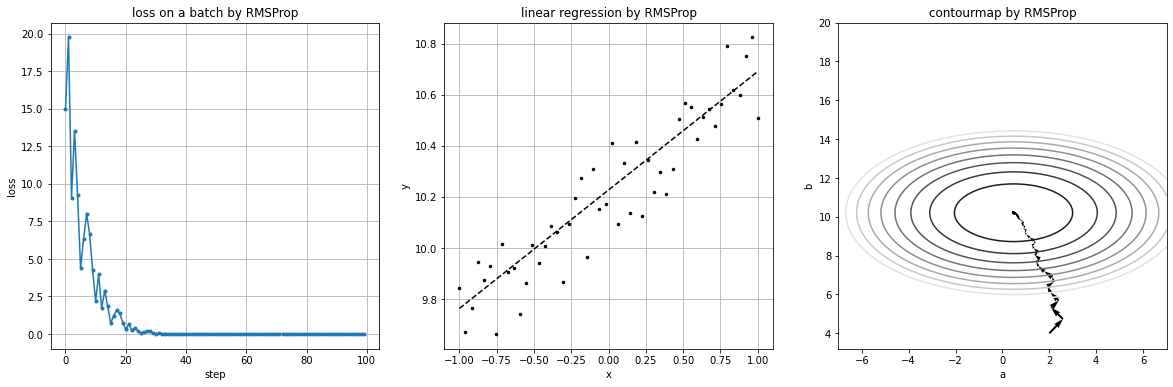

In [12]:
plt.figure(figsize=(20,6))

plt.subplot(1,3,1)
plt.plot(batch_loss, '.-')
plt.grid()
plt.xlabel('step')
plt.ylabel('loss')
plt.title('loss on a batch by RMSProp')

plt.subplot(1,3,2)
new_paths = np.array(paths).T
plt.plot(x_train, y_train, '.k', markersize=5)
plt.plot(x_train, new_paths[0,-1]*x_train+new_paths[1,-1], 'k--')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.title('linear regression by RMSProp')

plt.subplot(1,3,3)
w0 = np.linspace(-7, 7, 101)
w1 = np.linspace(5, 20, 101)
w0, w1 = np.meshgrid(w0, w1)
lossw = w0*0
for i in range(w0.shape[0]):
    for j in range(w0.shape[1]):
        wij = np.array([w0[i,j], w1[i,j]])
        lossw[i,j] = loss(wij, x_train, y_train)        
paths = np.array(paths).T
plt.contour(w0, w1, lossw, levels=np.linspace(0,10,10), norm=None, cmap=plt.cm.gray)
plt.quiver(paths[0,:-1], paths[1,:-1], paths[0,1:]-paths[0,:-1], paths[1,1:]-paths[1,:-1], scale_units='xy', angles='xy', scale=1, color='k')
plt.xlabel('a')
plt.ylabel('b')
plt.title('contourmap by RMSProp')

plt.show()

***
## 5. Adam (Adaptive moments)
<br>

#### Adam = Momentum + RMSProp
<br>
Adam은 현재까지 나온 optimizer 중에 가장 안정적인 것으로 알려져있습니다.<br>
기존 gradient의 두가지 문제점 (local minimum으로의 수렴 가능성과 learning_rate에 의존성)을 Momentum과 RMSProp를 섞어 동시에 해결하였습니다.



### Adam 수식
<br>
- 기존 Momentum에서 사용한 v와 RMSProp에서 사용한 r을 그대로 사용 <br>
- v와 r을 바로 사용하지 않고 따로 hat을 사용하는 이유는 학습 초기에 v와 r이 0으로 보통 설정이 되는데 이 0으로 편향되는 현상을 막기 위함<br>
(hat의 분모들을 학습을 할수록 1로 수렴)
<br>

## $$ v_{t+1} = \rho_1 v_t + (1 - \rho_1) \nabla f(\theta_t) $$
## $$ r_{t+1} = \rho_2 r_t + (1 - \rho_2)(\nabla f(\theta_t))^2 $$
## $$ \hat{v}_{t+1} = \frac{v_{t+1}}{1 - \rho_1^{t+1}} $$
## $$ \hat{r}_{t+1} = \frac{r_{t+1}}{1 - \rho_2^{t+1}} $$
## $$ \theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat{r}_{t+1} + \epsilon}} \hat{v}_{t+1} $$

In [13]:
# Adam

# 초깃값 설정
batch_size = 5
epochs = 10
w0 = np.array([2.0, 4.0])
epsilon = 1.0
delta = 1e-8
rho1 = 0.9 
rho2 = 0.999
s = np.zeros_like(w0)
r = np.zeros_like(w0) 
t = 0

paths= []
batch_loss = []

# 데이터 셔플링
np.random.seed(32)
idx = np.arange(len(x_train))
np.random.shuffle(idx)
shuffle_x_train = x_train[idx]
shuffle_y_train = y_train[idx]

# Adam 알고리즘 수행
for i in range(epochs) :
    for x_batch, y_batch in generate_batches(batch_size, shuffle_x_train, shuffle_y_train) :
        paths.append(w0)
        batch_loss.append(loss(w0, x_batch, y_batch))
        grad = loss_grad(w0, x_batch, y_batch)
        
        s = (rho1*s) + (1 - rho1)*grad
        r = (rho2*r) + (1 - rho2)*grad*grad
        t +=1
        s_hat = s/(1 - rho1**t)
        r_hat = r/(1 - rho2**t)
        
        direction = -s_hat
        lr = epsilon / (delta+np.sqrt(r_hat))
        dw = lr*direction
        w0 = w0+dw
    print(f'{i:.2f} \t {w0} \t {loss(w0, x_train, y_train)}')

0.00 	 [ 1.2953258  12.01271797] 	 1.751692897570844
1.00 	 [-0.60623078 10.7086366 ] 	 0.333172676047073
2.00 	 [0.6073808  9.26660497] 	 0.45297062036558977
3.00 	 [ 0.80298468 10.69386544] 	 0.14316191505661194
4.00 	 [ 0.2335748  10.12196078] 	 0.019931416060622445
5.00 	 [ 0.53586689 10.12339414] 	 0.010641728038095788
6.00 	 [ 0.50963885 10.30620454] 	 0.011354262208293346
7.00 	 [ 0.43079214 10.12703007] 	 0.009930933090918546
8.00 	 [ 0.50922641 10.25205113] 	 0.0075177800429005355
9.00 	 [ 0.46203172 10.17428469] 	 0.006924490523279064


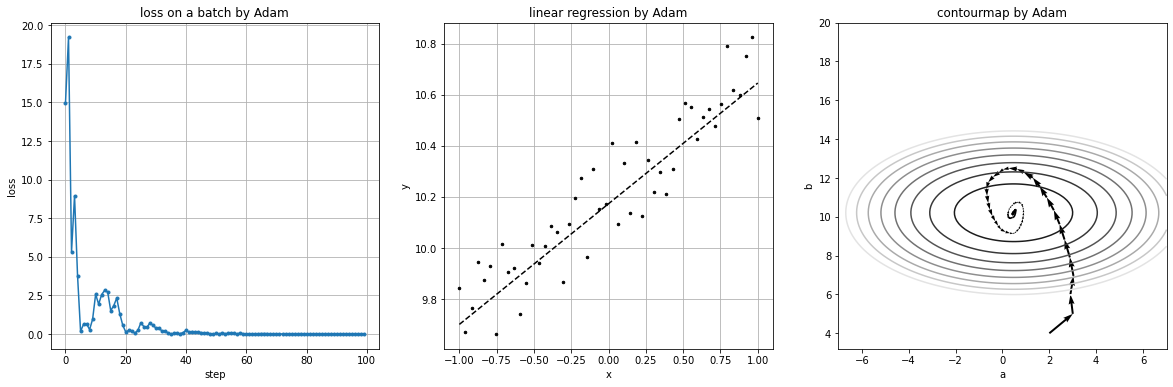

In [14]:
plt.figure(figsize=(20,6))

plt.subplot(1,3,1)
plt.plot(batch_loss, '.-')
plt.grid()
plt.xlabel('step')
plt.ylabel('loss')
plt.title('loss on a batch by Adam')

plt.subplot(1,3,2)
new_paths = np.array(paths).T
plt.plot(x_train, y_train, '.k', markersize=5)
plt.plot(x_train, new_paths[0,-1]*x_train+new_paths[1,-1], 'k--')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.title('linear regression by Adam')

plt.subplot(1,3,3)
w0 = np.linspace(-7, 7, 101)
w1 = np.linspace(5, 20, 101)
w0, w1 = np.meshgrid(w0, w1)
lossw = w0*0
for i in range(w0.shape[0]):
    for j in range(w0.shape[1]):
        wij = np.array([w0[i,j], w1[i,j]])
        lossw[i,j] = loss(wij, x_train, y_train)        
paths = np.array(paths).T
plt.contour(w0, w1, lossw, levels=np.linspace(0,10,10), norm=None, cmap=plt.cm.gray)
plt.quiver(paths[0,:-1], paths[1,:-1], paths[0,1:]-paths[0,:-1], paths[1,1:]-paths[1,:-1], scale_units='xy', angles='xy', scale=1, color='k')
plt.xlabel('a')
plt.ylabel('b')
plt.title('contourmap by Adam')

plt.show()

Adam의 Contourmap을 보면 최솟값 근처로 나선형으로 움직이는 현상 관찰 가능